# This notebook is to calculate the Rayleight optical depth at a given altitude for the airLUSI project (PI K. Turpie). 

### Link to the project:
### https://www.nasa.gov/feature/goddard/2019/new-moon-seeking-sensor-aims-to-improve-earth-observations

In [1]:
# imports
import os
import re
import glob
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.matlib as npm
from scipy.interpolate import interp1d
from matplotlib.legend_handler import HandlerLine2D
import time

In [2]:
%matplotlib notebook

In [3]:
def BodhaineROT(Ps = 1013.25, Ts = 288.15, CO2 = 360, λ = np.arange(250,890,5), z = 0, ϕ = 45):
    """ This function is to calculate the
    Rayleigh optical thickness according to
    Bodhaine et al., 1999
    Inputs: P: pressure in mbar, 
    T: temprature in K, 
    CO2: concentration in ppm
    λ: wavelength (nm)
    z: Altitude (meters)
    ϕ: Latitude (degrees)
    BodhaineBM: Run Bodhaine Benchmark case if True. If False read inputs
    Outputs: λ (nm), Rayleigh Optical Thickness τr(λ)
    """
    # Convert wavelength to μm
    λ_μm = λ/1e3
    λ_μm = λ_μm[:,np.newaxis]
    
    # define contstants according to Bodhaine et al., 1999
    T0 = 273.15 # Reference Temprature (K)
    ma = 15.0556*CO2/1e6 + 28.9595 # molecular weight for dry air normalized to CO2 concentration
    A = 6.0221367e23 # Avogadro's Number (molecules/mol)
    mmr_N2 = 78.084
    mmr_O2 = 20.946
    mmr_Ar = 0.934
    
    # calcaulated for T = 288.15 K and 1013.25 mb
    n300_1 = 1e-8*(8060.51 + (2480990/(132.274 - 1/(λ_μm**2))) + (17455.7/(39.32957 - 1/(λ_μm**2))))
    n_co2_1 = n300_1*(1 + 0.54*(CO2*1e-6 - 0.0003))
    n = n_co2_1 + 1
    
    F_N2 = 1.034 + 3.17e-4 * (1/(λ_μm**2))
    F_O2 = 1.096 + 1.385e-3 * (1/(λ_μm**2)) + 1.448e-4 * (1/(λ_μm**4))
    F_Ar = 1.00
    F_CO2 = 1.15
    
    # Calculate King's Factor spectrally
    F_air_co2 = (78.084*F_N2 + 20.946*F_O2 + 0.934*F_Ar + CO2*1e-4*F_CO2) / (mmr_N2 + mmr_O2 + mmr_Ar + CO2*1e-4)

    # Calculate the molar volume given the temprature within the layer of the atmosphere
    Ns = 1e-3*(A/22.4141)*(T0/Ts)
    
    # Calculate the scattering cross section of the air molecules
    σ_air = ((24*np.pi**3*(n**2 - 1)**2)/ ((λ_μm*1e-4)**4*Ns**2*(n**2 + 2)**2)) * F_air_co2
    
    zc = 0.73737*z + 5517.56
    g0 = 980.6160*(1 - 0.0026373*np.cos(2*np.deg2rad(ϕ))) + 0.0000059*(np.cos(2*np.deg2rad(ϕ)))**2 
    g = g0 - (3.085462e-4 + 2.27e-7*np.cos(2*np.deg2rad(ϕ)))*z \
    + (7.254e-11 + 1e-13*np.cos(2*np.deg2rad(ϕ)))*z**2 - \
    (1.517e-17 + 6e-20*np.cos(2*np.deg2rad(ϕ)))*z**3

    # Calculate the Rayleigh optical thickness
    τr = σ_air * (1e3*Ps*A)/(ma*g)
    ρpol = 6*(F_air_co2-1)/(7*F_air_co2 + 3)
    
    return λ, τr, σ_air, ρpol

### Calculate the Rayleigh optical depth at the sea level

In [4]:
λ, τr_sl, _, _ = BodhaineROT()

In [5]:
# Read in atmosphere profile
ProfPath = '../data/atmmod/mcclams.dat'
profile = np.loadtxt(ProfPath)
P = profile[:,1]
T = profile[:,2]
H = profile[:,0]

altitude = 21e3
P_alt = interp1d(H, P)(altitude/1e3)
T_alt = interp1d(H, T)(altitude/1e3)

### Calculate the Rayleigh optical depth at the ER-s aircraft altitude of 21 km

In [6]:
λ, τr_alt, _, _ = BodhaineROT(Ps=P_alt, Ts=T_alt, z=21e3)

<IPython.core.display.Javascript object>


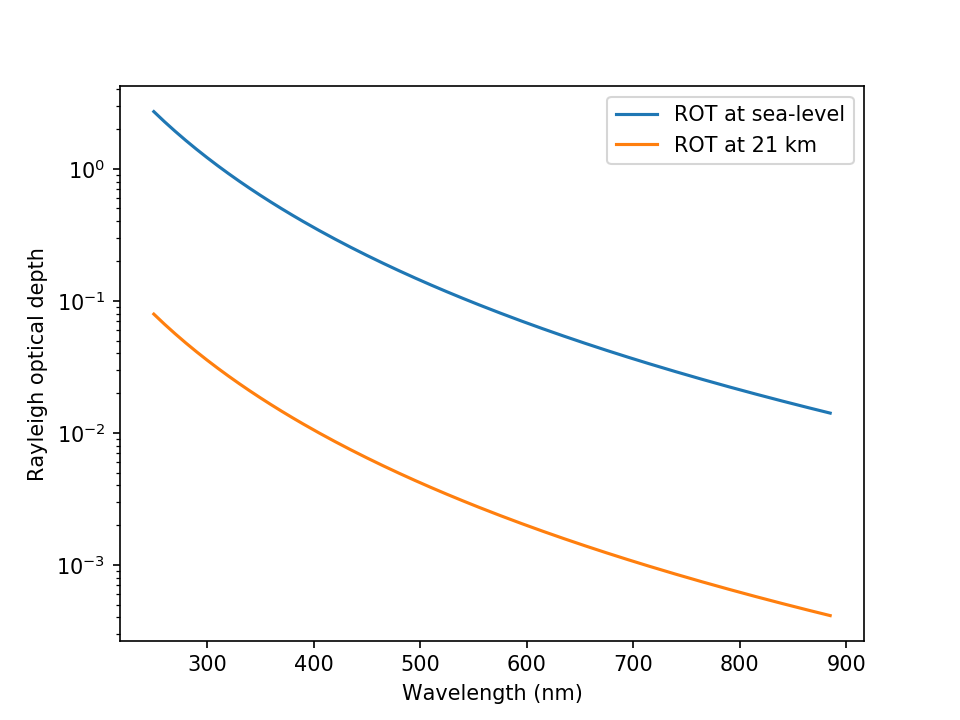

In [7]:
plt.figure()
plt.semilogy(λ, τr_sl, label='ROT at sea-level');
plt.plot(λ, τr_alt, label='ROT at 21 km');
plt.xlabel('Wavelength (nm)')
plt.ylabel('Rayleigh optical depth')
plt.legend()

### Now we can calculate the direct transmittance of the Rayleigh atmosphere above the aircraft given the lunar zenith and view zenith

In [8]:
lunar_zenith = 90 - 65
T_ray = np.exp(-τr_alt/np.cos(np.deg2rad(lunar_zenith)))

<IPython.core.display.Javascript object>


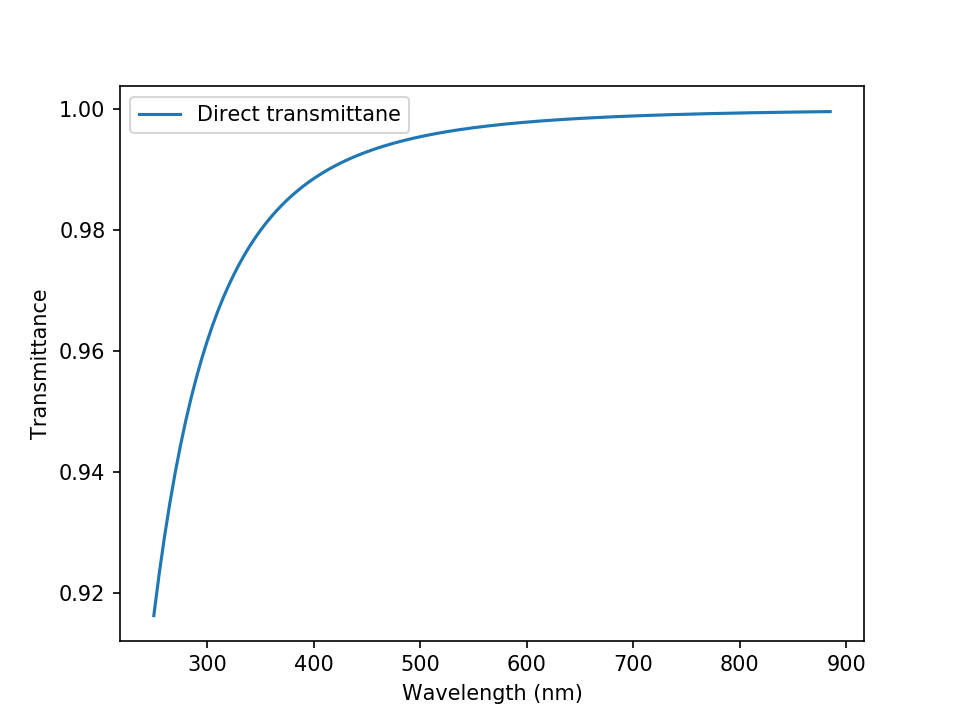

In [9]:
plt.figure();
plt.plot(λ, T_ray, label='Direct transmittane')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmittance')
plt.legend()